In [1]:
%reload_ext watermark
%watermark -a "Hugo Mendes"

Author: Hugo Mendes



# Houses Prediction

## Objetivo: Gerar um modelo de previsão a partir do dataset escolhido Kaggle para inferir novos valores para casas que serão passadas pela aplicação de API do projeto.
## Etapas: Vamos utilizar de todas as etapas de um projeto Data Science (Carregando dos dados, Conhecimento dos dados, Análise Exploratória, Limpeza e Pré Processamento, Geração do Modelo, Validações e Avaliações, Importar o modelo para o deploy (produção).
## Metas: Pretendo alcançar um modelo de previsão com o poder de explicabilidade maior que 85% e que o modelo seja estatisticamente significativo e também que minimizamos ao máximo o MAE (erro absoluto médio) e RMSE (raiz do erro quadrático médio).

### 1. Importação das Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, mean_squared_error
from sklearn.linear_model import LinearRegression

In [3]:
# versões dos pacotes
%watermark --iversions

matplotlib: 3.10.7
numpy     : 2.3.5
pandas    : 2.3.3
seaborn   : 0.13.2
sklearn   : 1.8.0



### 2. Carregando os dados

In [4]:
dataset = "Housing.csv"
df_casas = pd.read_csv(dataset, sep=",")

In [5]:
# Exibindo linhas inicias do DataFrame
df_casas.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [6]:
# Exibindo linhas finais do Dataframe
df_casas.tail()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished
544,1750000,3850,3,1,2,yes,no,no,no,no,0,no,unfurnished


### 3. Conhecendo os dados

In [7]:
# Informações do Dataframe
df_casas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [8]:
# Quantidade de atributos (colunas)
len(df_casas.columns)

13

In [9]:
# Quantidade de linhas
df_casas.shape[0]

545

In [10]:
# Quantidade de registros
df_casas.shape[0] * df_casas.shape[1]

7085

In [11]:
# Tipos de dados
df_casas.dtypes

price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object

In [12]:
df_casas.select_dtypes(include=np.number).columns # Colunas numéricas

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking'], dtype='object')

In [13]:
df_casas.select_dtypes(include="object").columns # Colunas categoricas

Index(['mainroad', 'guestroom', 'basement', 'hotwaterheating',
       'airconditioning', 'prefarea', 'furnishingstatus'],
      dtype='object')

### 4. Análise Exploratória

In [14]:
# Valores ausentes
df_casas.loc[df_casas.isnull().any(axis=1)]

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus


In [15]:
df_casas.isnull().sum().sum()

np.int64(0)

In [16]:
# Linhas duplicadas
df_casas[df_casas.duplicated()]

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus


In [17]:
df_casas[df_casas.duplicated(subset=df_casas.drop(columns="price").columns, keep=False)].sort_values(by="area", ascending=False)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
435,3290000,4040,2,1,1,yes,no,no,no,no,0,no,unfurnished
414,3423000,4040,2,1,1,yes,no,no,no,no,0,no,unfurnished
408,3430000,4000,2,1,1,yes,no,no,no,no,0,no,unfurnished
496,2695000,4000,2,1,1,yes,no,no,no,no,0,no,unfurnished
544,1750000,3850,3,1,2,yes,no,no,no,no,0,no,unfurnished
458,3115000,3850,3,1,2,yes,no,no,no,no,0,no,unfurnished
385,3570000,3640,2,1,1,yes,no,no,no,no,0,no,unfurnished
525,2345000,3640,2,1,1,yes,no,no,no,no,0,no,unfurnished
411,3430000,2145,3,1,3,yes,no,no,no,no,0,yes,furnished
407,3465000,2145,3,1,3,yes,no,no,no,no,0,yes,furnished


In [18]:
media_casa_1 = np.mean(df_casas.loc[[408,496], "price"]) # média do preço
df_casas.loc[408, "price"] = media_casa_1 # substituindo pela média
df_casas.drop(496, axis=0, inplace=True) # removendo a outra linha

In [19]:
media_casa_2 = np.mean(df_casas.loc[[458,544], "price"])
df_casas.loc[458, "price"] = media_casa_2
df_casas.drop(544, axis=0, inplace=True) 

In [20]:
media_casa_3 = np.mean(df_casas.loc[[385,525], "price"])
df_casas.loc[385, "price"] = media_casa_3
df_casas.drop(525, axis=0, inplace=True) 

In [21]:
df_casas[df_casas.duplicated(subset=df_casas.drop(columns="price").columns, keep=False)].sort_values(by="area", ascending=False)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
435,3290000,4040,2,1,1,yes,no,no,no,no,0,no,unfurnished
414,3423000,4040,2,1,1,yes,no,no,no,no,0,no,unfurnished
411,3430000,2145,3,1,3,yes,no,no,no,no,0,yes,furnished
407,3465000,2145,3,1,3,yes,no,no,no,no,0,yes,furnished
427,3332000,2145,3,1,2,yes,no,yes,no,no,0,yes,furnished
436,3290000,2145,3,1,2,yes,no,yes,no,no,0,yes,furnished


In [22]:
# Medidas estatisticas nas colunas numéricas
df_casas.describe(include=np.number)

,price,area,bedrooms,bathrooms,stories,parking
count,5.420000e+02,542.000000,542.000000,542.000000,542.000000,542.000000
mean,4.777518e+06,5157.850554,2.968635,1.287823,1.808118,0.697417
std,1.868885e+06,2173.886659,0.737768,0.503407,0.868470,0.862418
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.465000e+06,3588.000000,2.250000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.766250e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [23]:
# Medidas estatisticas nas colunas categoricas
df_casas.describe(include="object")

,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus
count,542,542,542,542,542,542,542
unique,2,2,2,2,2,2,3
top,yes,no,no,no,no,no,semi-furnished
freq,465,445,351,517,370,414,227


In [24]:
# Calculando o coeficiente de variação das variáveis numéricas
for column in df_casas.select_dtypes(include=np.number).columns:
    cv = (df_casas[column].std() / df_casas[column].mean()) * 100
    print(f"A variável {column} tem um coeficiente de variação de {cv:.2f}%")

A variável price tem um coeficiente de variação de 39.12%
A variável area tem um coeficiente de variação de 42.15%
A variável bedrooms tem um coeficiente de variação de 24.85%
A variável bathrooms tem um coeficiente de variação de 39.09%
A variável stories tem um coeficiente de variação de 48.03%
A variável parking tem um coeficiente de variação de 123.66%


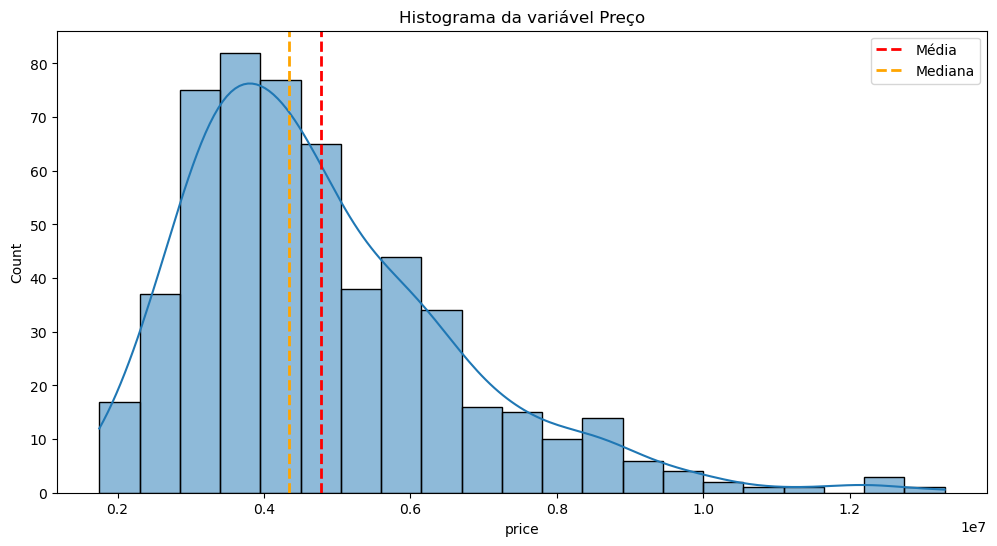

In [25]:
# Distribuição dos atributos
plt.figure(figsize=(12,6))
sns.histplot(df_casas["price"], kde=True)
plt.axvline(df_casas["price"].mean(), color = "red", linestyle = '--', linewidth = 2, label = f"Média")
plt.axvline(df_casas["price"].median(), color = "orange", linestyle = '--', linewidth = 2, label = f"Mediana")
plt.title("Histograma da variável Preço")
plt.legend()
plt.show()

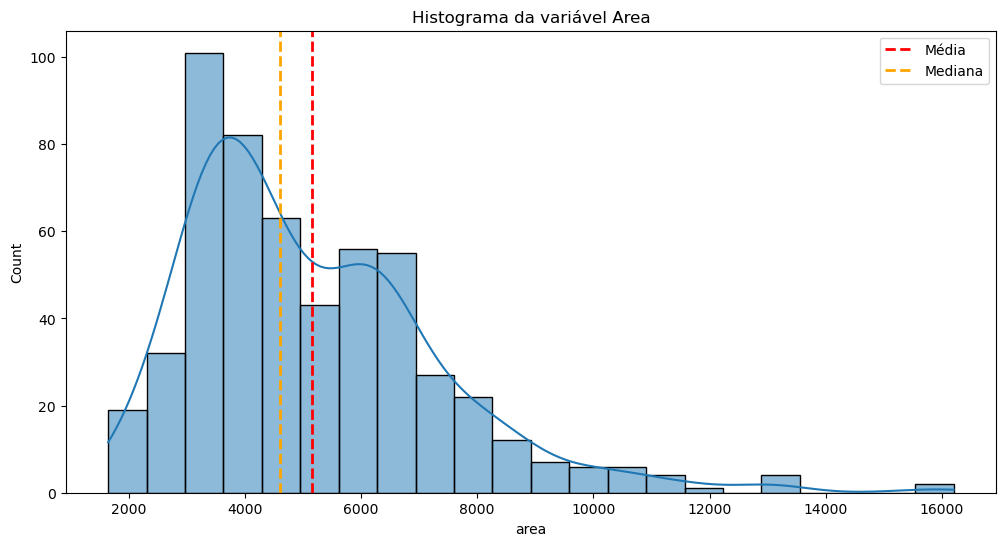

In [26]:
plt.figure(figsize=(12,6))
sns.histplot(df_casas["area"], kde=True)
plt.axvline(df_casas["area"].mean(), color = "red", linestyle = '--', linewidth = 2, label = f"Média")
plt.axvline(df_casas["area"].median(), color = "orange", linestyle = '--', linewidth = 2, label = f"Mediana")
plt.legend()
plt.title("Histograma da variável Area")
plt.show()

In [27]:
colunas_distribuicao = [
    "bedrooms", "bathrooms", "stories", "parking", 
    "mainroad", "guestroom", "basement", "hotwaterheating",
    "airconditioning", "prefarea", "furnishingstatus"
]

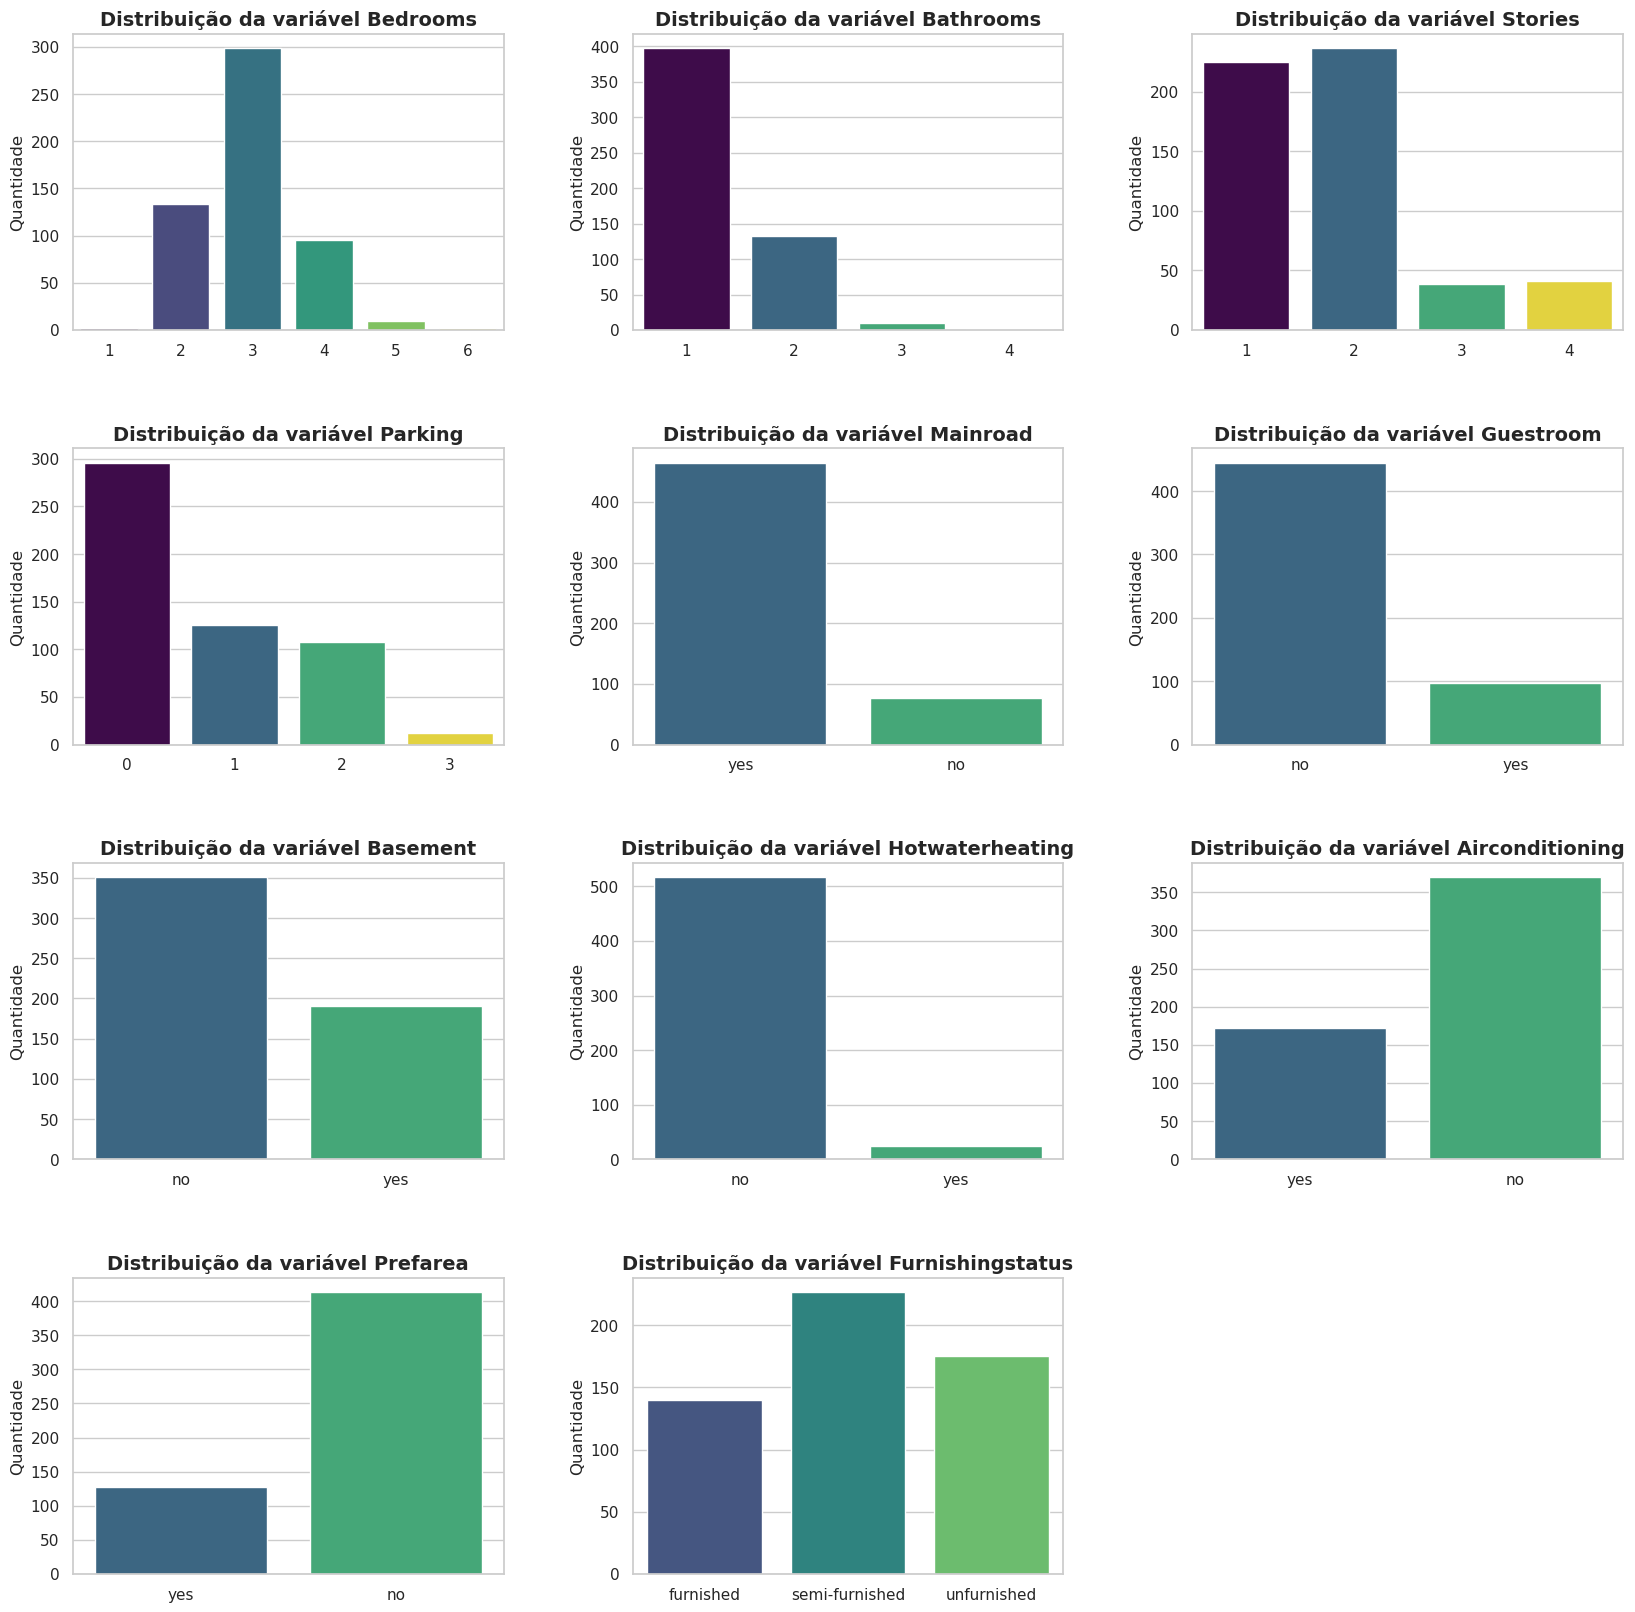

In [28]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
for i, coluna in enumerate(colunas_distribuicao):
    plt.subplot(4, 3, i + 1) # Cria o grid 4x3
    
    # Criando o countplot
    ax = sns.countplot(data=df_casas, x=coluna, palette="viridis", hue=coluna, legend=False)
    
    # Customização de cada gráfico
    plt.title(f"Distribuição da variável {coluna.capitalize()}", fontsize=14, fontweight="bold")
    plt.xlabel("") 
    plt.ylabel("Quantidade")
plt.show()

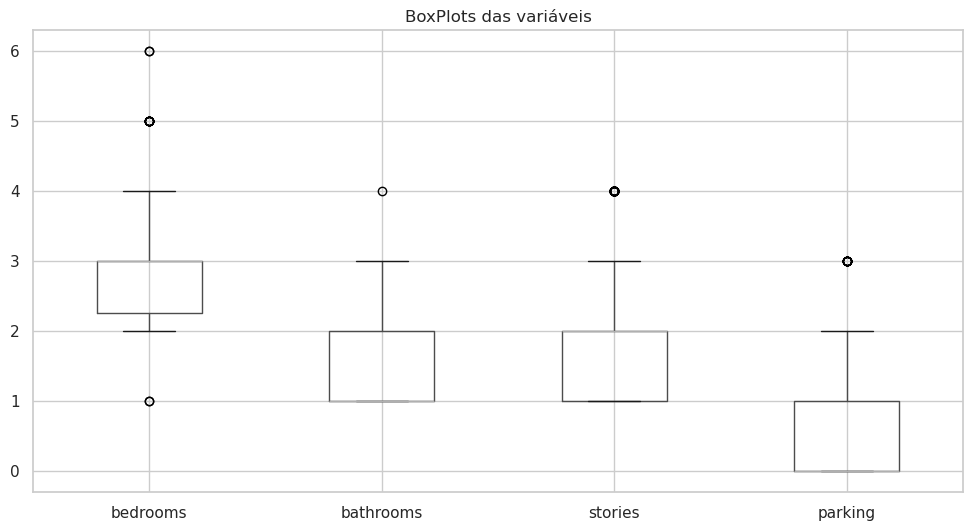

In [29]:
# Detecção de outliers
df_casas.drop(columns=["price","area"]).select_dtypes(include=np.number).boxplot(figsize=(12,6))
plt.title("BoxPlots das variáveis")
plt.show()

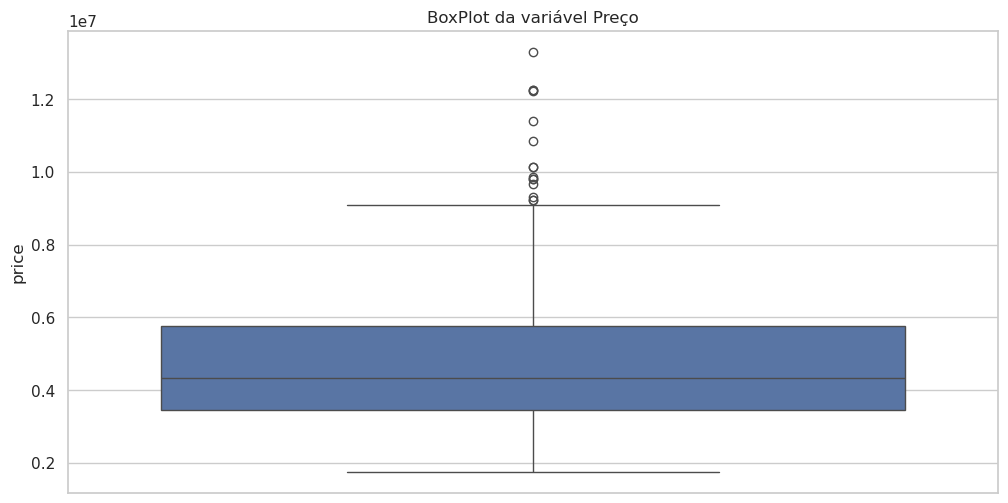

In [30]:
plt.figure(figsize=(12,6))
sns.boxplot(df_casas["price"])
plt.title("BoxPlot da variável Preço")
plt.show()

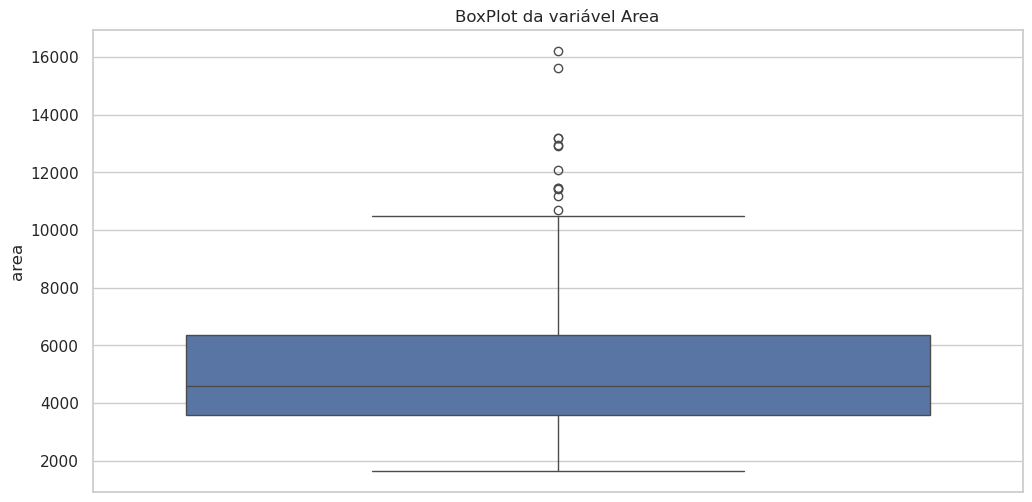

In [31]:
plt.figure(figsize=(12,6))
sns.boxplot(df_casas["area"])
plt.title("BoxPlot da variável Area")
plt.show()

### 5. Limpeza e Pré Processamento

In [32]:
df_casas.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

In [33]:
# Renomeando as colunas para português
colunas_pt = ["preco", "area", "quartos", "banheiros", "andares", "acesso_rodovia",
             "quarto_hospede", "porao", "aquecimento_agua", "ar_condicionado", "vagas_estacionameno", 
             "area_preferencial", "status_mobilia"]

In [34]:
colunas_df_pt = {coluna_df: coluna_br for coluna_df, coluna_br in zip(df_casas.columns, colunas_pt)} # dicionário para renomear as colunas

In [35]:
df_limpo = df_casas.rename(columns=colunas_df_pt) # novo df para o pré processamento (com as colunas em portugues)

In [36]:
# Tratanto outliers da variável preço
IC = df_limpo["preco"].quantile(0.75) - df_limpo["preco"].quantile(0.25) # tamanho da caixa do boxplot
formula_preco = df_limpo["preco"].quantile(0.75) + (1.5 * IC) # formula para encontrar valores extremos a partir do ponto máximo

In [37]:
# Visualizando os registros com outliers em preço
outliers_preco = df_limpo[df_limpo["preco"] > formula_preco]

In [38]:
outliers_preco

,preco,area,quartos,banheiros,andares,acesso_rodovia,quarto_hospede,porao,aquecimento_agua,ar_condicionado,vagas_estacionameno,area_preferencial,status_mobilia
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
5,10850000,7500,3,3,1,yes,no,yes,no,yes,2,yes,semi-furnished
6,10150000,8580,4,3,4,yes,no,no,no,yes,2,yes,semi-furnished
7,10150000,16200,5,3,2,yes,no,no,no,no,0,no,unfurnished
8,9870000,8100,4,1,2,yes,yes,yes,no,yes,2,yes,furnished
9,9800000,5750,3,2,4,yes,yes,no,no,yes,1,yes,unfurnished


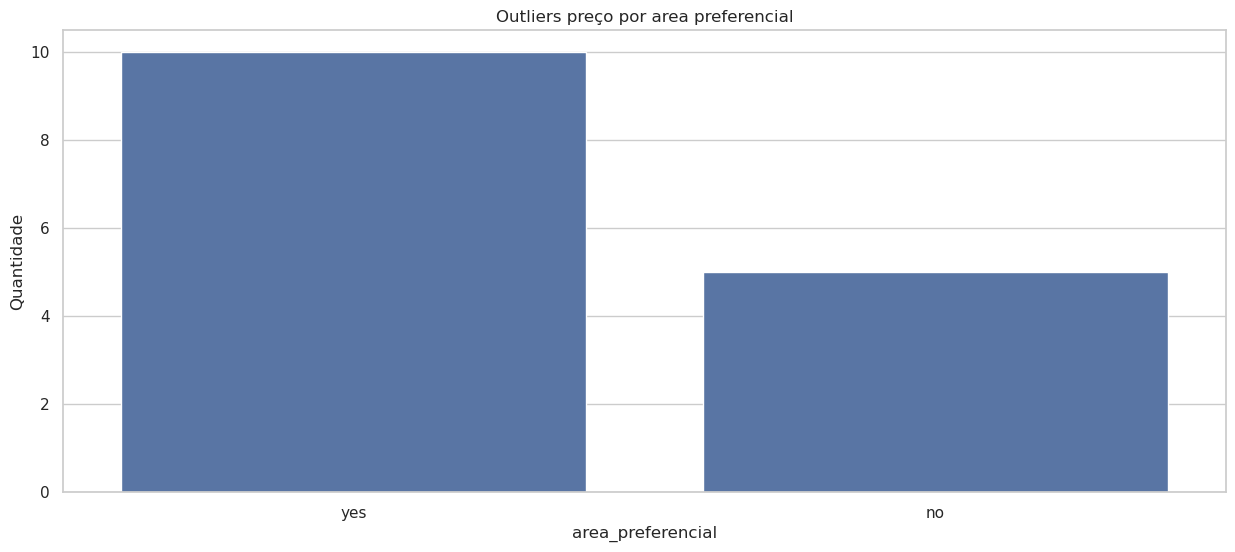

In [39]:
plt.figure(figsize=(15,6))
sns.countplot(data=outliers_preco, x="area_preferencial")
plt.ylabel("Quantidade")
plt.title("Outliers preço por area preferencial")
plt.show()

In [40]:
# Tratando outliers da variável area
# Antes disso vamos passar a area de pés quadrados para metros quadrados
df_limpo["area"] = df_limpo["area"] * 0.0929

In [41]:
IC2 = df_limpo["area"].quantile(0.75) - df_limpo["area"].quantile(0.25) # tamanho da caixa do boxplot
formula_area = df_limpo["area"].quantile(0.75) + (1.5 * IC2) # formula para encontrar valores extremos a partir do ponto máximo

In [42]:
outliers_area = df_limpo[df_limpo["area"] > formula_area]

In [43]:
outliers_area

,preco,area,quartos,banheiros,andares,acesso_rodovia,quarto_hospede,porao,aquecimento_agua,ar_condicionado,vagas_estacionameno,area_preferencial,status_mobilia
7,10150000,1504.9800,5,3,2,yes,no,no,no,no,0,no,unfurnished
10,9800000,1226.2800,3,1,2,yes,no,yes,no,yes,2,yes,furnished
56,7343000,1062.7760,4,1,2,yes,no,yes,no,no,1,yes,semi-furnished
64,7000000,1038.1575,3,1,1,yes,no,yes,no,yes,1,yes,furnished
66,6930000,1226.2800,2,1,1,yes,no,yes,yes,no,1,no,furnished
69,6790000,1123.1610,4,2,2,yes,no,no,no,no,2,yes,furnished
125,5943000,1449.2400,3,1,1,yes,no,no,no,yes,2,no,semi-furnished
129,5873000,1064.6340,3,1,3,yes,no,no,no,no,2,yes,semi-furnished
186,5110000,1059.9890,2,1,2,yes,no,no,no,no,0,yes,furnished
191,5040000,994.0300,3,1,2,yes,yes,yes,no,no,0,no,semi-furnished


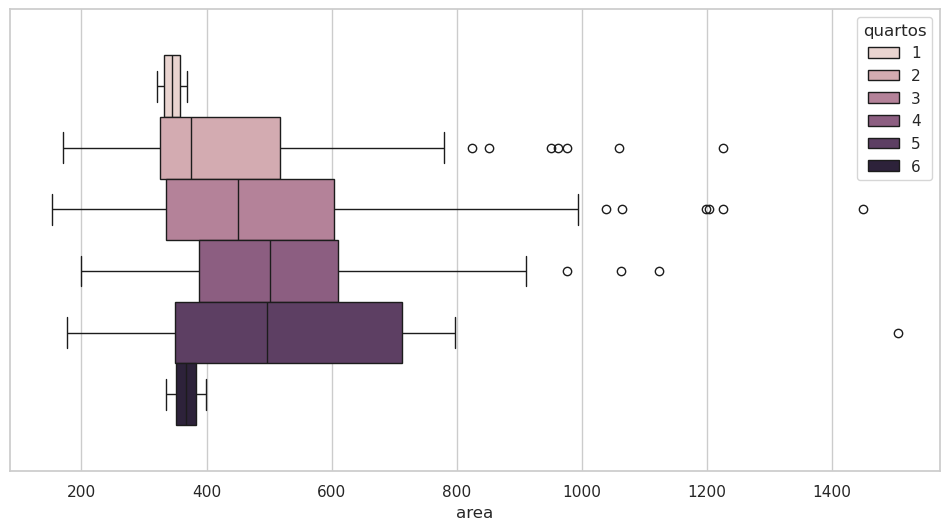

In [44]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_limpo,x="area", hue="quartos")
plt.show()

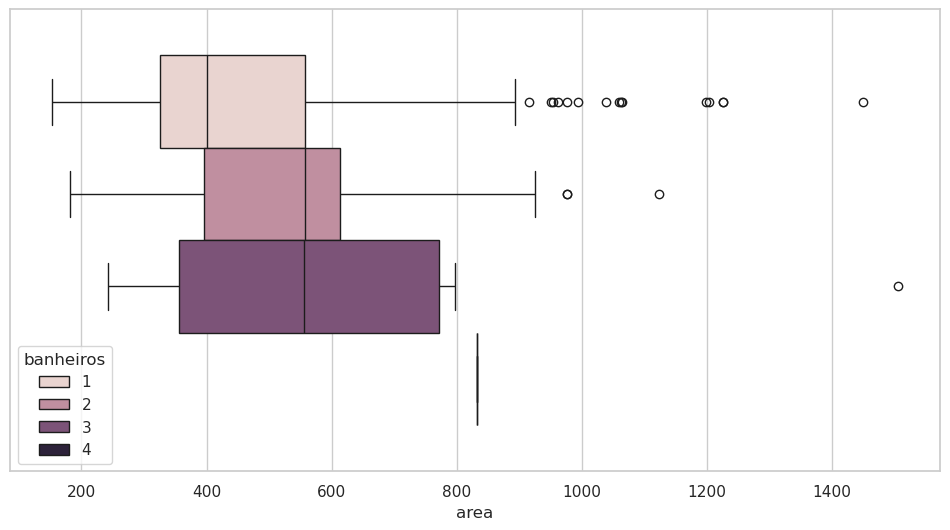

In [45]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_limpo,x="area", hue="banheiros")
plt.show()

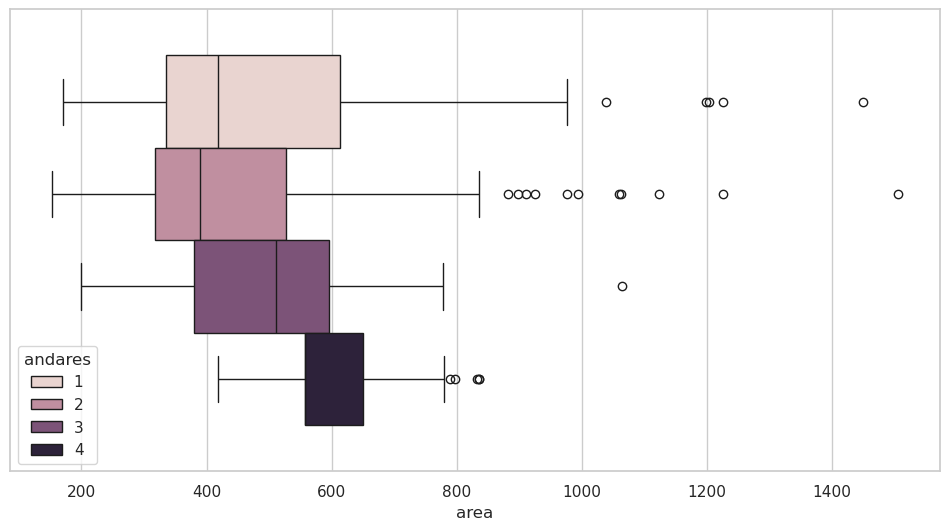

In [46]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_limpo,x="area", hue="andares")
plt.show()